## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [54]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

## Apply a distortion correction to raw images.

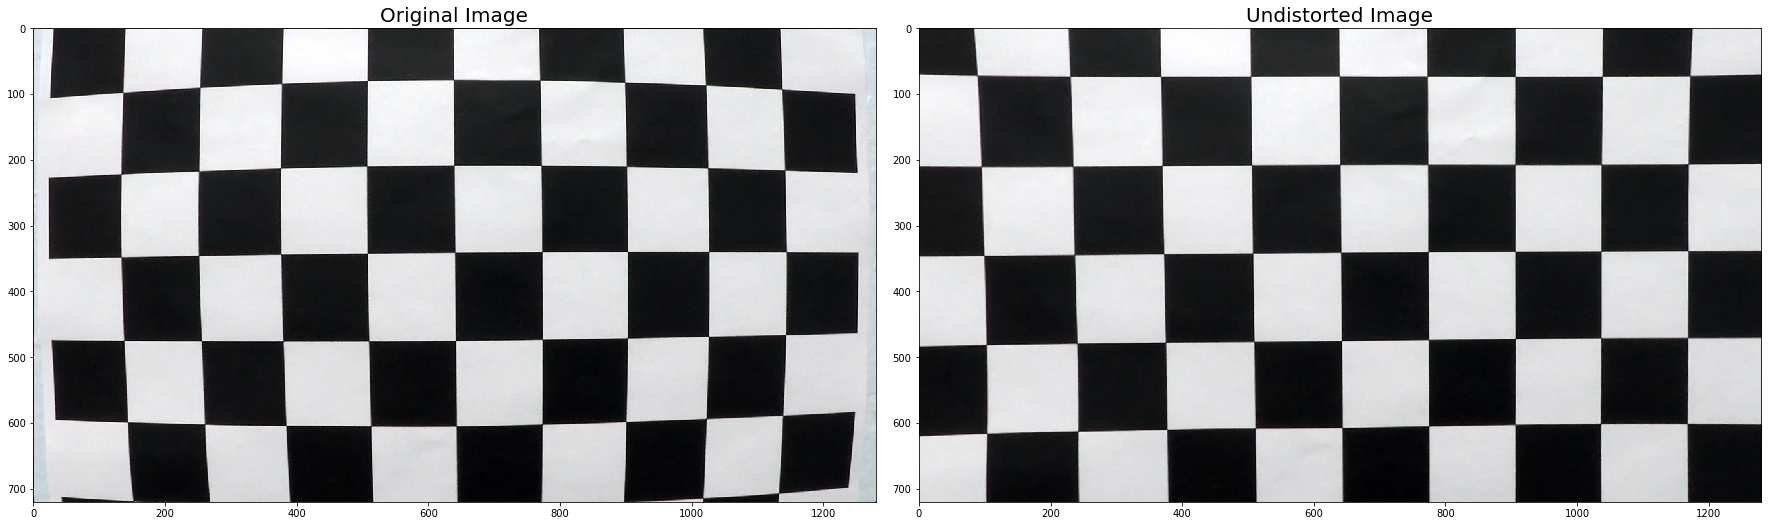

In [81]:
img = cv2.imread('camera_cal/calibration1.jpg')
undist= cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color transforms, gradients, etc., to create a thresholded binary image.

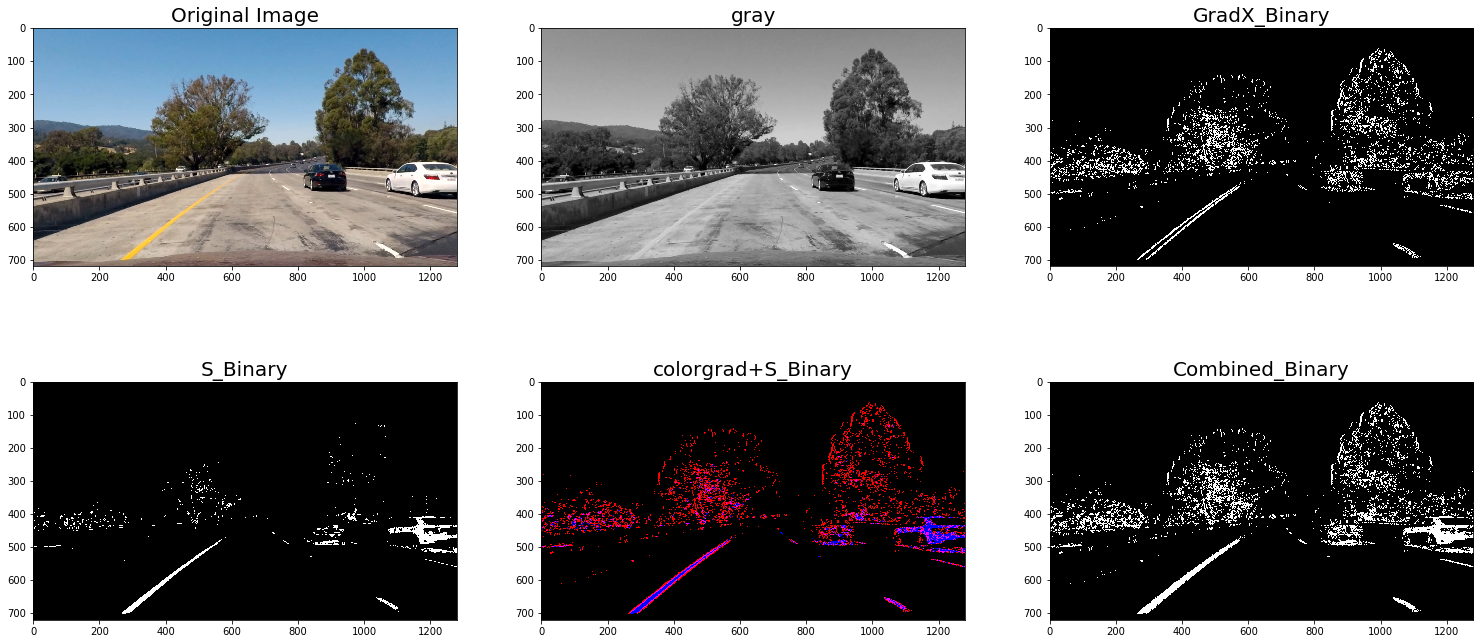

In [87]:
img = cv2.imread('test_images/test1.jpg')
undist= cv2.undistort(img, mtx, dist, None, mtx)
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
#l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
# Sobel x
sobel_kernel=3
sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0,sobel_kernel) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
# Threshold x gradient
sx_thresh=(20, 100)
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
# Threshold color channel
s_thresh=(170, 255)
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
# Stack each channel
color_binary = np.dstack(( sxbinary,np.zeros_like(sxbinary), s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1 

# Plot the result
#f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(2, 3, figsize=(24, 20))
#f = plt.subplots(3, 2)
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(2,3,1)


#f.tight_layout()
#plt.figure()
#plt.subplots(3, 2, figsize=(24, 20))
ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)

ax2 = fig.add_subplot(2,3,2)
ax2.imshow(gray, cmap='gray')
ax2.set_title('gray', fontsize=20)

ax3 = fig.add_subplot(2,3,3)
ax3.imshow(sxbinary, cmap='gray')
ax3.set_title('GradX_Binary', fontsize=20)

ax4 = fig.add_subplot(2,3,4)
ax4.imshow(s_binary, cmap='gray')
ax4.set_title('S_Binary', fontsize=20)

ax5 = fig.add_subplot(2,3,5)
ax5.imshow(color_binary)
ax5.set_title('colorgrad+S_Binary', fontsize=20)

ax6 = fig.add_subplot(2,3,6)
ax6.imshow(combined_binary, cmap='gray')
ax6.set_title('Combined_Binary', fontsize=20)


plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## perspective transform

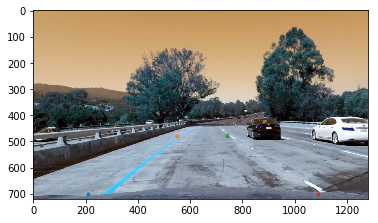

In [88]:
plt.imshow(undist)
plt.plot(210,700,'.')
plt.plot(550,480,'.')
plt.plot(740,480,'.')
plt.plot(1090,700,'.')

In [89]:
def warp(img,video_flag):
    img_size = (img.shape[1], img.shape[0])
    # source points
    if video_flag:
        src = np.float32(
        [[300,700],
         [620,480],
         [740,480],
         [1090,700]])
    else:
        src = np.float32(
            [[210,700],
             [550,480],
             [740,480],
             [1090,700]])
    # destination points
    dst = np.float32(
        [[300,700],
         [300,100],
         [900,100],
         [900,700]])
    # compute the p
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
test_warped,M,Minv = warp(undist,video_flag=False)

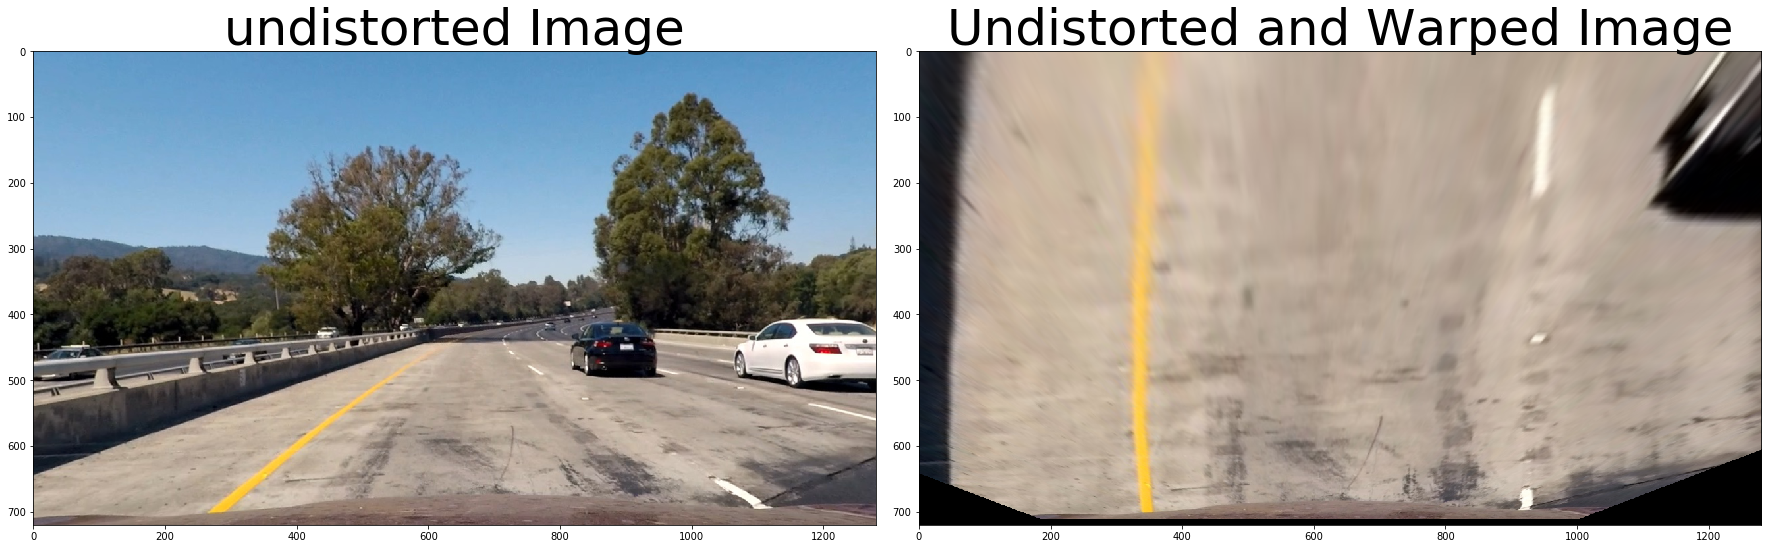

In [90]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('undistorted Image', fontsize=50)
ax2.imshow(test_warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [92]:
# Define a class to receive the characteristics of each line detection
class Line(object):
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.useprev = False

In [93]:

Leftline=Line()
Rightline=Line()

## Threshold define

In [94]:
def Threshold_image(img):
    undist= cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    B_channel = hls[:,:,0]
    G_channel = hls[:,:,1]
    R_channel = hls[:,:,2]

    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobel_kernel=3
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_thresh=(50, 200)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_thresh=(170, 255)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold color channel
    R_thresh=(170, 255)
    R_binary = np.zeros_like(s_channel)
    R_binary[(R_channel >= R_thresh[0]) & (R_channel <= R_thresh[1])] = 1
    
    # Stack each channel
    #color_binary = np.dstack(( sxbinary,np.zeros_like(sxbinary), s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary [(s_binary == 1) | (sxbinary == 1) ] = 1 
    #combined_binary [(combined_binary == 1) | (R_binary == 1) ] = 1 
    
    combined_binary_NoR = np.zeros_like(sxbinary)
    combined_binary_NoR[(s_binary == 1) | (sxbinary == 1) ] = 1 
    
    # Plot the result
    f, (ax1, ax2, ax3, ax4, ax5,ax6,ax7) = plt.subplots(7, 1, figsize=(24, 20))
    #f.tight_layout()

    ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)

    ax2.imshow(sxbinary, cmap='gray')
    ax2.set_title('GradX_Binary', fontsize=20)


    ax3.imshow(s_channel, cmap='gray')
    ax3.set_title('S_Binary', fontsize=20)

    ax4.imshow(combined_binary_NoR, cmap='gray')
    ax4.set_title('combined_binary_NoR', fontsize=20)

    ax5.imshow(combined_binary, cmap='gray')
    ax5.set_title('Combined_Binary', fontsize=20)

    ax6.imshow(gray, cmap='gray')
    ax6.set_title('gray', fontsize=20)

    ax7.imshow(R_binary, cmap='gray')
    ax7.set_title('R_binary', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    
    return combined_binary

In [95]:
#Threshold for video
def Threshold_video(img):
    undist= cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    B_channel = hls[:,:,0]
    G_channel = hls[:,:,1]
    R_channel = hls[:,:,2]

    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobel_kernel=3
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_thresh=(20, 200)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_thresh=(20, 50)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold color channel
    R_thresh=(100, 255)
    R_binary = np.zeros_like(s_channel)
    R_binary[(R_channel >= R_thresh[0]) & (R_channel <= R_thresh[1])] = 1
    
    # Stack each channel
    #color_binary = np.dstack(( sxbinary,np.zeros_like(sxbinary), s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary [(s_binary == 1) | (sxbinary == 1) ] = 1 
    combined_binary [(combined_binary == 1) | (R_binary == 1) ] = 1 
    
    combined_binary_NoR = np.zeros_like(sxbinary)
    combined_binary_NoR[(s_binary == 1) | (sxbinary == 1) ] = 1 
   
    
    # Plot the result
    f, (ax1, ax2, ax3, ax4, ax5,ax6,ax7) = plt.subplots(7, 1, figsize=(24, 20))
    #f.tight_layout()

    ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)

    ax2.imshow(sxbinary, cmap='gray')
    ax2.set_title('GradX_Binary', fontsize=20)


    ax3.imshow(s_channel, cmap='gray')
    ax3.set_title('S_Binary', fontsize=20)

    ax4.imshow(combined_binary_NoR, cmap='gray')
    ax4.set_title('combined_binary_NoR', fontsize=20)

    ax5.imshow(combined_binary, cmap='gray')
    ax5.set_title('Combined_Binary', fontsize=20)

    ax6.imshow(gray, cmap='gray')
    ax6.set_title('gray', fontsize=20)

    ax7.imshow(R_binary, cmap='gray')
    ax7.set_title('R_binary', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    
    return combined_binary

### First frame fit

In [96]:
def FirstFrameFit(binary_warped):
   # locate the center of the lines based on the bottom half image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    plt.figure()
    plt.plot(histogram)
    #ax7=plt.figure()
    #ax7=plt.plot(histogram)
    #f, (ax1) = plt.subplots(1, 1, figsize=(24, 20))
    #ax1=plt.plot(histogram)
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint-100])
    rightx_base = np.argmax(histogram[midpoint+100:2*midpoint-50]) + midpoint
    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return leftx, rightx, lefty, righty,left_fit, right_fit

## Next video frame uses previous line to find the lane line pixes

In [97]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def SecondFramefit(binary_warped):    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 40
    #if len(Leftline.current_fit)<4:
    left_fit = Leftline.current_fit[-1]
    right_fit = Rightline.current_fit[-1]
    #else:
    #    left_fit = 0.7*np.mean(Leftline.current_fit[-4:-1],0)+0.3*Leftline.current_fit[-1:][0]
    #    right_fit = 0.7*np.mean(Rightline.current_fit[-4:-1],0)+0.3*Rightline.current_fit[-1:][0]
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    print('  leftx'+str(len(leftx)))
    print('  rightx'+str(len(rightx)))
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
     # if number of points less than 2000, just use previous fit
    if len(leftx)<1000:
        left_fit = Leftline.current_fit[-1]
        Leftline.useprev = True
    if len(rightx)<1000:
        right_fit = Rightline.current_fit[-1]
        Leftline.useprev = True
    
    return leftx, rightx, lefty, righty,left_fit, right_fit
# Generate x and y values for plotting
#ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

## Curvature Calculation

In [98]:
def CurvCal(binary_warped, leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = binary_warped.shape[0]*ym_per_pix
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    # Calculate Offset
    left_fitx = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_fitx = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
    offset= binary_warped.shape[1]* xm_per_pix/2 -(left_fitx+(right_fitx-left_fitx)/2)
    #print(left_curverad, 'm', right_curverad, 'm', offset,'m')
    return left_curverad, right_curverad, offset

# Process Images

In [99]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [100]:
def pipe_line(img,video_flag=True):
   
    #combined_binary=Threshold(img)
    
    # add mask for image
    if video_flag:
        combined_binary=Threshold_video(img)
        vertices = np.array([[(250,700),(630, 460), (710, 460), (1100,700)]], dtype=np.int32)
    else:
        combined_binary=Threshold_image(img)
        vertices = np.array([[(180,700),(580, 460), (760, 460), (1100,700)]], dtype=np.int32)
    # adding mask for video
    #vertices = np.array([[(200,700),(600, 460), (760, 460), (1100,700)]], dtype=np.int32)
    combined_binary=region_of_interest(combined_binary, vertices)
    
    plt.figure()
    plt.imshow(combined_binary,cmap='gray')
    
    # persepctive transform (warp the binary image) 
    binary_warped, M, Minv = warp(combined_binary, video_flag)
    plt.figure()
    plt.imshow(binary_warped)
    # Fit the lane lines
    if Leftline.detected == False:
        leftx, rightx, lefty, righty,left_fit, right_fit=FirstFrameFit(binary_warped)
        if len(leftx)>1 and len(rightx)>1:
            Leftline.detected=True
            Rightline.detected=True
            # x values of the last n fits of the line
            #Left.recent_xfitted.append(leftx) 
            #average x values of the fitted line over the last n iterations
            #self.bestx = None     
            #polynomial coefficients averaged over the last n iterations
            #self.best_fit = None  
            #polynomial coefficients for the most recent fit
            Leftline.current_fit[0] =left_fit 
            Rightline.current_fit[0] = right_fit 
            #Leftline.current_fit.reshape(1,3) 
            #Rightline.current_fit.reshape(1,3)  
            #radius of curvature of the line in some units
            #self.radius_of_curvature = None 
            #distance in meters of vehicle center from the line
            #self.line_base_pos = None 
            #difference in fit coefficients between last and new fits
            #self.diffs = np.array([0,0,0], dtype='float') 
            #x values for detected line pixels
            Leftline.allx = leftx  
            #y values for detected line pixels
            Rightline.ally = rightx
    else:
        leftx, rightx, lefty, righty,left_fit, right_fit=SecondFramefit(binary_warped)
    
    # Curv Calculation
    
    left_curv, right_curv, offset =CurvCal(binary_warped, leftx, lefty, rightx, righty)
    

    
    #print('CurvRatio'+str(left_curv/right_curv))
    #if (left_curv/right_curv)<5 and (left_curv/right_curv)>0.4:
    Leftline.current_fit.append(left_fit)
    Rightline.current_fit.append(right_fit)
    #else:
    #    leftx, rightx, lefty, righty,left_fit, right_fit=FirstFrameFit(binary_warped)
        
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # plotting
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    undist= cv2.undistort(img, mtx, dist, None, mtx)
    result = cv2.addWeighted(undist , 1, newwarp, 0.3, 0) 
    
        
    
    
    TextMessageLeft='Left Curvature:'+ str(round(left_curv,2)) 
    TextMessageRight='Right Curvature:'+ str(round(right_curv,2))
    TextMessageOffset='Offset:'+ str(round(offset,2))
    TextMessageprev='useprev:'+ str(Leftline.useprev)
    font = cv2.FONT_HERSHEY_SIMPLEX
    TopLeftCornerOfText = (100,100)
    fontScale = 1.5
    fontColor = (255,255,255)
    lineType = 2
    result= cv2.putText(result,TextMessageLeft, TopLeftCornerOfText, font, fontScale,fontColor,lineType)
    result= cv2.putText(result,TextMessageRight, (100,200), font, fontScale,fontColor,lineType)
    result= cv2.putText(result,TextMessageOffset, (100,300), font, fontScale,fontColor,lineType)
    result= cv2.putText(result,TextMessageprev, (100,400), font, fontScale,fontColor,lineType)
    # reset useprev
    Leftline.useprev = False
    return result
 

In [101]:
Leftline=Line()
Leftline.current_fit

[array([False])]

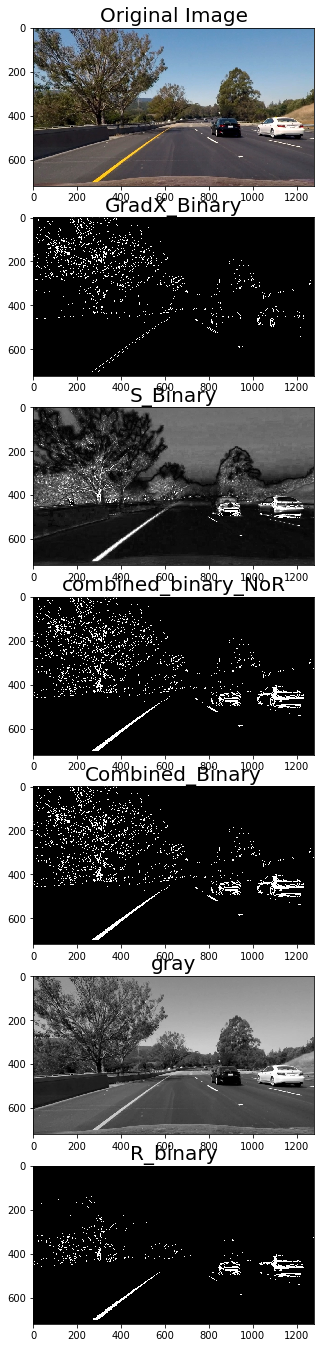

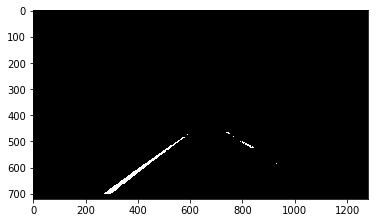

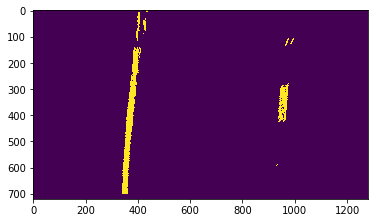

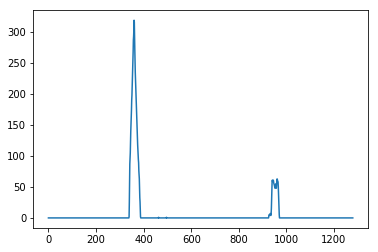

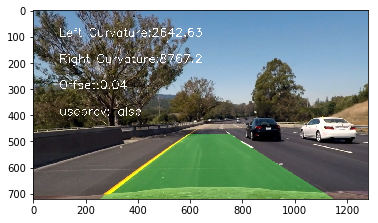

  leftx2091
  rightx2723


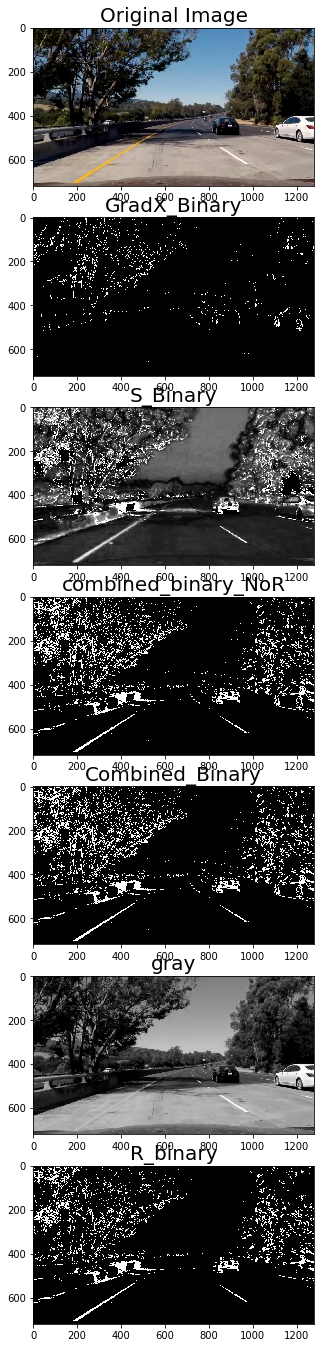

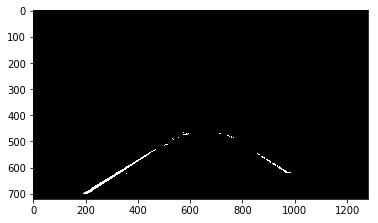

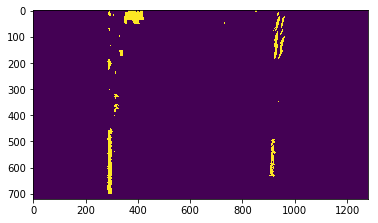

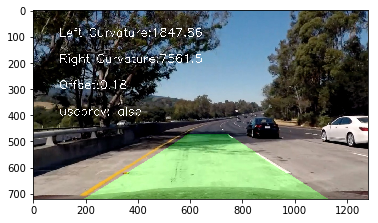

  leftx14182
  rightx3320


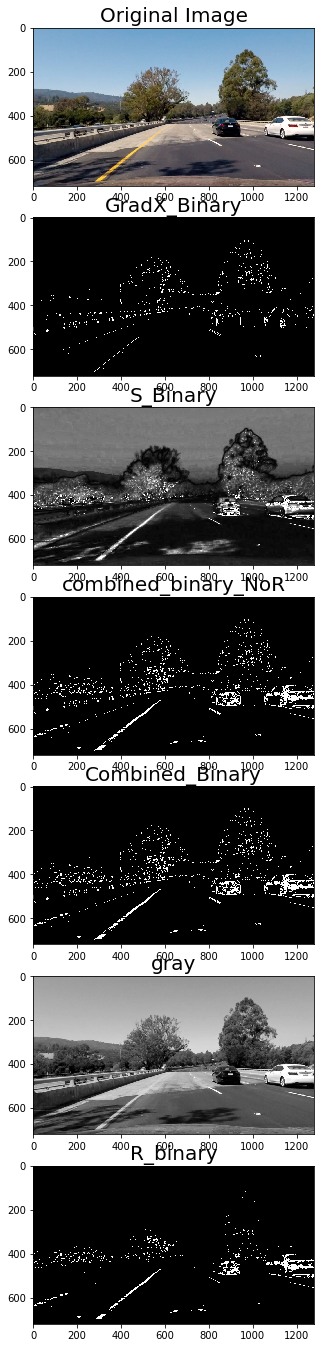

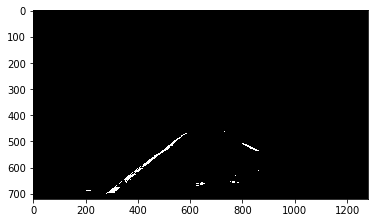

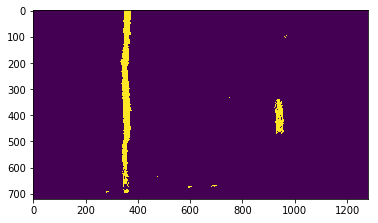

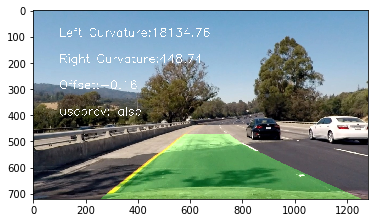

  leftx13793
  rightx1805


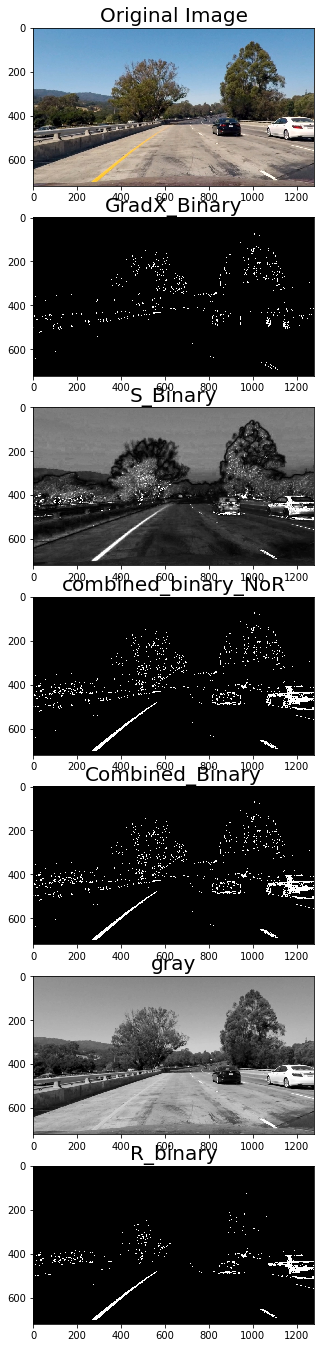

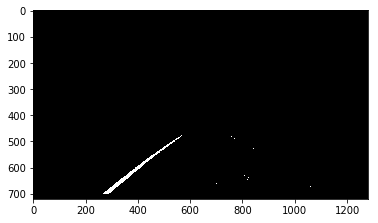

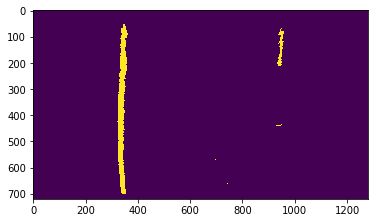

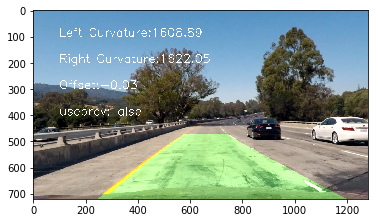

  leftx15663
  rightx6516


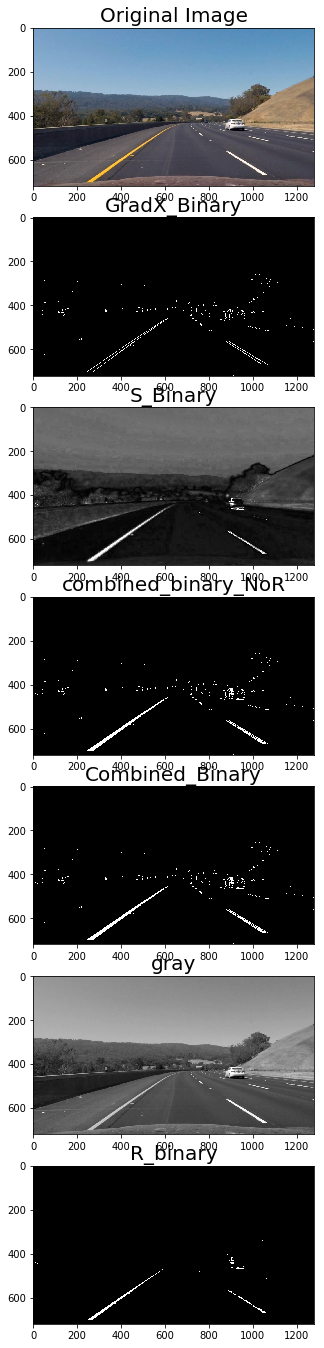

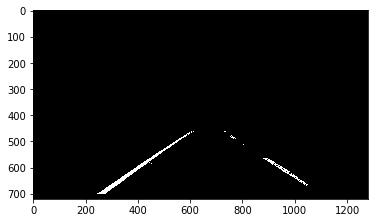

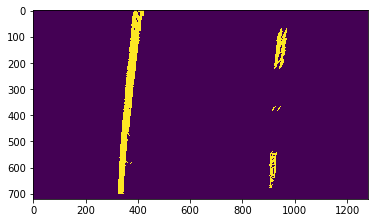

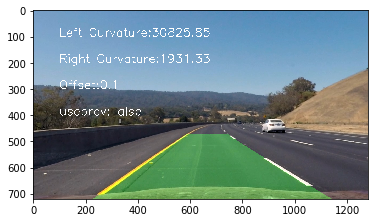

  leftx13030
  rightx4519


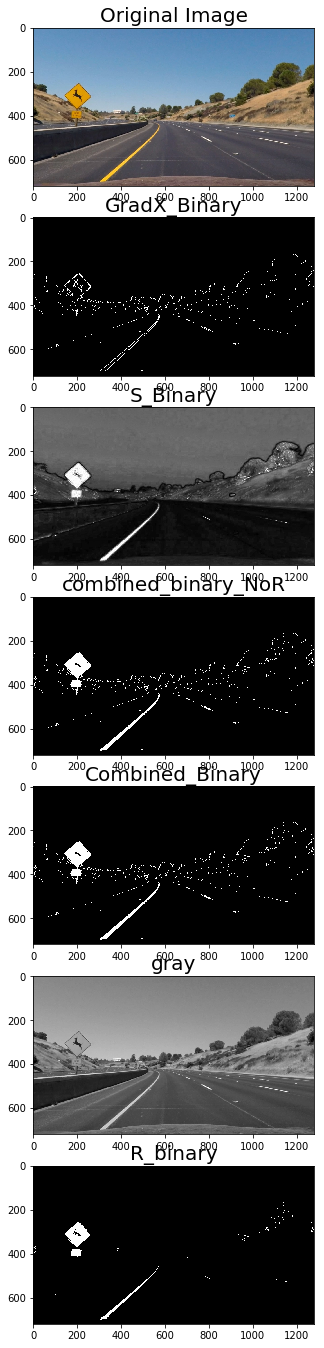

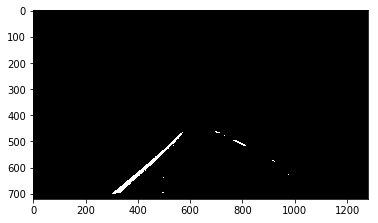

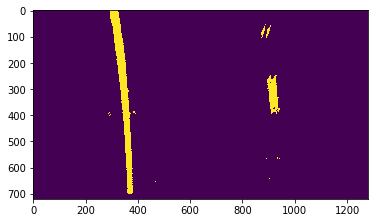

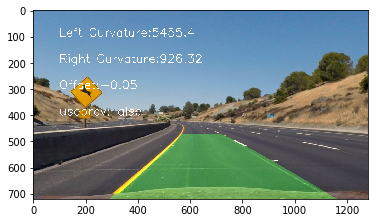

  leftx4739
  rightx15921


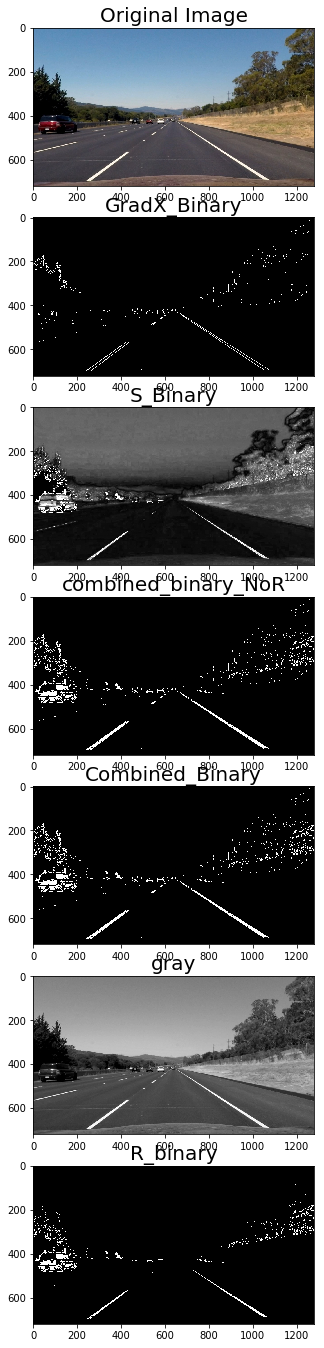

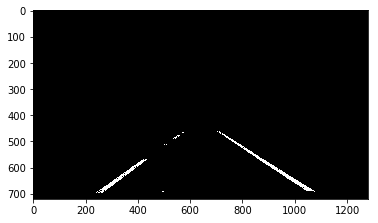

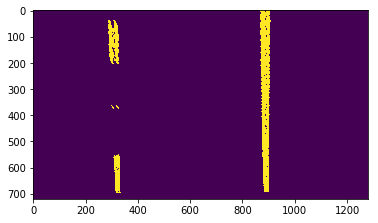

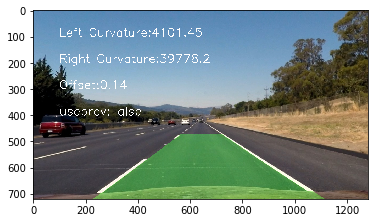

  leftx18233
  rightx5499


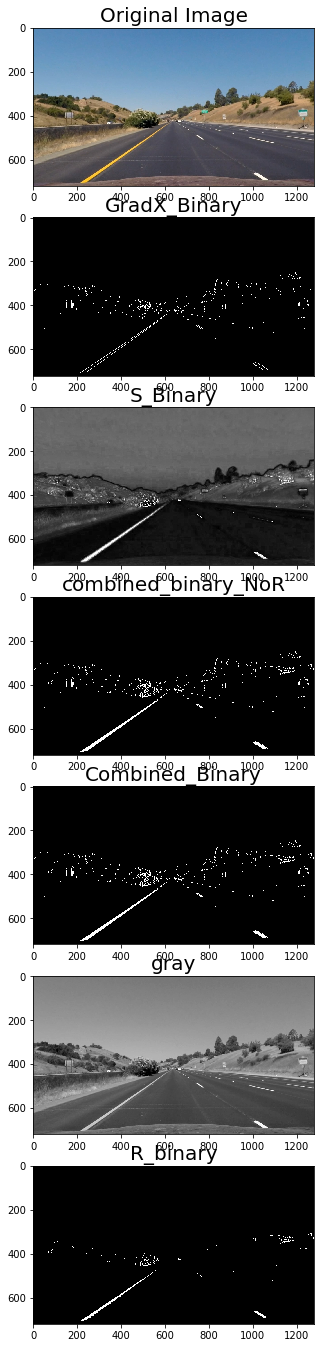

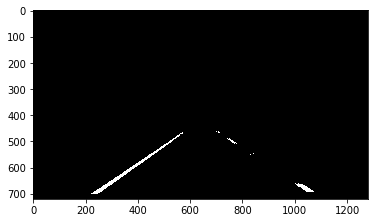

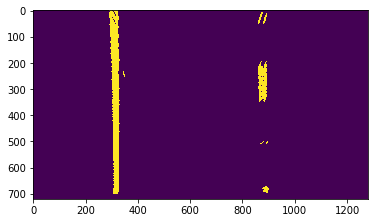

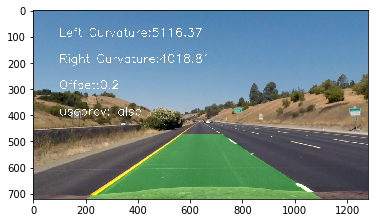

In [102]:
### Test image pipeline
Leftline.detected = False
import os
imageList=os.listdir("test_images/")
for image in imageList:
    FileName = "test_images/" + image
    img = cv2.imread(FileName)
    final_img = cv2.cvtColor(pipe_line(img,video_flag=False), cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(final_img)
    plt.show()
    FileName_out = "test_images_out/" + image
    cv2.imwrite(FileName_out,final_img)

In [ ]:
Leftline.detected =False
import re 

def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

import os
imageList=sorted_nicely(os.listdir("VideoFrame/"))
for image in imageList:
    FileName = "VideoFrame/" + image
    img = cv2.imread(FileName)
    final_img = cv2.cvtColor(pipe_line(img, video_flag=True), cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(final_img)
    plt.show()
    plt.title(image)
    FileName_out = "test_videos_out/" + image
    cv2.imwrite(FileName_out,final_img)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
Leftline.detected =False
output = 'output_images/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipe_line) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

## Convert video to pic frame (run only once)
import cv2

print(cv2.__version__)

vidcap = cv2.VideoCapture('challenge_video.mp4')

success,image = vidcap.read()

count = 0

success = True

while success:

  cv2.imwrite("VideoFrame/frame%d.jpg" % count, image)     # save frame as JPEG file
  
  success,image = vidcap.read()
  
  print ('Read a new frame: ', success)
  
  count += 1

In [ ]:
Leftline.detected =False
import os
imageList=sorted(os.listdir("VideoFrame/"))
for image in imageList:
    FileName = "VideoFrame/" + image
    img = cv2.imread(FileName)
    final_img = cv2.cvtColor(pipe_line(img, video_flag=True), cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(final_img)
    plt.show()
    plt.title(image)
    FileName_out = "test_videos_out/" + image
    cv2.imwrite(FileName_out,final_img)